In [1]:
!pip install pyspark
!pip install nltk
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=0c10cf9d39313b3dbd2d43ca5f64abffba7ecff2368b6bdb117959fc87976745
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import gdown
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, ArrayType
from pyspark.sql.functions import col, udf, split, explode, size, array_remove, array_contains, regexp_replace, lower
from pyspark.ml.feature import StopWordsRemover, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [3]:
file_id = '1w2c49UUWnZHbWZ_ryKaWGhIzSF7QuvYJ'
url = f'https://drive.google.com/uc?id={file_id}'
output_path = '/content/mental_health.csv'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)
else:
    print(f"The file '{output_path}' already exists.")

Downloading...
From: https://drive.google.com/uc?id=1w2c49UUWnZHbWZ_ryKaWGhIzSF7QuvYJ
To: /content/mental_health.csv
100%|██████████| 13.1M/13.1M [00:00<00:00, 37.1MB/s]


In [4]:
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder\
        .master("local")\
        .appName("RDD")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark
sc = spark.sparkContext
sc.setCheckpointDir('checkpoint/')

In [5]:
spark.conf.set("spark.sql.shuffle.partitions", 16)
spark.conf.set("spark.default.parallelism", 16)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 104857600)

In [6]:
df = spark.read.csv(output_path, header=True, inferSchema=True)

In [7]:
df.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|dear american tee...|    0|
|nothing look forw...|    1|
|music recommendat...|    0|
|im done trying fe...|    1|
|worried  year old...|    1|
+--------------------+-----+
only showing top 5 rows



In [8]:
# Display summary statistics for numerical columns
df.describe().show()

# Display the schema of the DataFrame
df.printSchema()

+-------+--------------------+-------------------+
|summary|                text|              label|
+-------+--------------------+-------------------+
|  count|               27977|              27977|
|   mean|                NULL|0.49462058119169316|
| stddev|                NULL| 0.4999799966498138|
|    min|                    |                  0|
|    max|zoomposting real ...|                  1|
+-------+--------------------+-------------------+

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



In [9]:
duplicate_count = df.count() - df.dropDuplicates().count()
print("Duplicate count:", duplicate_count)

Duplicate count: 5


In [10]:
df = df.dropDuplicates()

In [11]:
from pyspark.sql.functions import length, avg

df = df.withColumn("length", length("text"))

In [12]:
df_gede = df.filter(col('length') >= 4096)
df_gede.count()

136

In [13]:
df = df.subtract(df_gede)

In [14]:
df.describe().show()

+-------+--------------------+-------------------+-----------------+
|summary|                text|              label|           length|
+-------+--------------------+-------------------+-----------------+
|  count|               27836|              27836|            27836|
|   mean|                NULL|   0.49285098433683|436.9363414283661|
| stddev|                NULL|0.49995786946205906|542.3475517942358|
|    min|                    |                  0|                2|
|    max|zoomposting real ...|                  1|             4087|
+-------+--------------------+-------------------+-----------------+



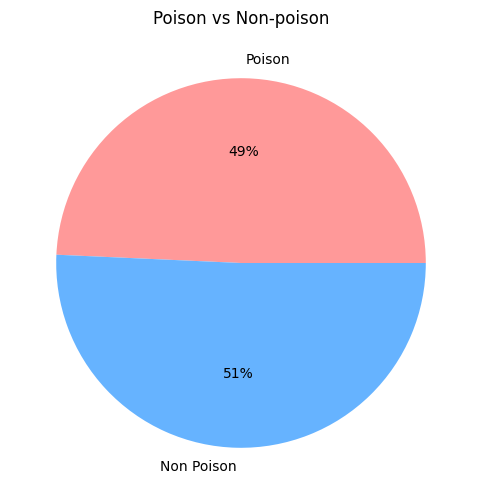

In [15]:
# Assuming 'label' is a boolean column in your DataFrame
sarcastic_counts = df.groupBy("label").count().collect()

# Extract counts
non_sarcastic_count = sarcastic_counts[0]["count"]
sarcastic_count = sarcastic_counts[1]["count"]

# Prepare data for pie chart
labels = ['Poison', 'Non Poison']
sizes = [non_sarcastic_count, sarcastic_count]
colors = ['#ff9999', '#66b3ff']

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=colors)
plt.title('Poison vs Non-poison')

# Display the pie chart
plt.show()


In [16]:
def extract_text(text):
    # Add more patterns as needed
    patterns = {
      r"\bim\b": "i am",
      r"\byoure\b": "you are",
      r"\bhes\b": "he is",
      r"\bshes\b": "she is",
      r"\bwere\b": "we are",
      r"\btheyre\b": "they are",
      r"\bive\b": "i have",
      r"\byouve\b": "you have",
      r"\bweve\b": "we have",
      r"\btheyve\b": "they have",
      r"\bwasnt\b": "was not",
      r"\bwont\b": "will not",
      r"\bcant\b": "cannot",
      r"\bdont\b": "do not",
      r"\bdoesnt\b": "does not",
      r"\bdidnt\b": "did not",
      r"\bhavent\b": "have not",
      r"\bhasnt\b": "has not",
      r"\bhadnt\b": "had not",
      r"\barent\b": "are not",
      r"\bwerent\b": "were not",
      r"\bisnt\b": "is not",
      r"\byoull\b": "you will",
      r"\bwell\b": "we will",
      r"\btheyll\b": "they will",
      r"\bill\b": "i will",
      r"\bhell\b": "he will",
      r"\bshell\b": "she will",
      r"\bitll\b": "it will",
      r"\bshed\b": "she would",
      r"\bhed\b": "he would",
      r"\bid\b": "i would",
      r"\byoud\b": "you would",
      r"\bwed\b": "we would",
      r"\btheyd\b": "they would",
      r"\bcouldve\b": "could have",
      r"\bshouldve\b": "should have",
      r"\bwouldve\b": "would have",
      r"\bwhos\b": "who is",
      r"\bwhats\b": "what is",
      r"\bwheres\b": "where is",
      r"\bwhens\b": "when is",
      r"\bwhys\b": "why is",
      r"\bhows\b": "how is",
      r"\bwhod\b": "who would",
      r"\bwhatd\b": "what would",
      r"\bwhered\b": "where would",
      r"\bwhend\b": "when would",
      r"\bwhyd\b": "why would",
      r"\bhowd\b": "how would",
      r"\bwholl\b": "who will",
      r"\bwhatll\b": "what will",
      r"\bwherell\b": "where will",
      r"\bwhenll\b": "when will",
      r"\bwhyll\b": "why will",
      r"\bhowll\b": "how will",
      r"\bwhore\b": "who are",
      r"\bwhatre\b": "what are",
      r"\bwherere\b": "where are",
      r"\bwhenre\b": "when are",
      r"\bwhyre\b": "why are",
      r"\bhowre\b": "how are",
      r"\bthats\b": "that is",
      r"\bthiss\b": "this is",
      r"\btheres\b": "there is",
      r"\bheres\b": "here is",
      r"\bits\b": "it is",
      r"\bwhove\b": "who have",
      r"\bwhatve\b": "what have",
      r"\bwhereve\b": "where have",
      r"\bwhenve\b": "when have",
      r"\bwhyve\b": "why have",
      r"\bhowve\b": "how have",
      r"\bimma\b": "i am going to",
      r"\bgonna\b": "going to",
      r"\bgotta\b": "got to",
      r"\bwanna\b": "want to",
      r"\bhafta\b": "have to",
      r"\bkinda\b": "kind of",
      r"\bsorta\b": "sort of",
      r"\blemme\b": "let me",
      r"\boutta\b": "out of",
      r"\bgotcha\b": "got you",
      # add more contractions and their expanded forms
    }

    # Function to apply substitution to each token in the array
    def process_token(token):
       for pattern, replacement in patterns.items():
           token = re.sub(pattern, replacement, token)
       return token

    processed_text = process_token(text)

    return processed_text


# Register the function as a UDF (User Defined Function)
extract_text_udf = udf(extract_text, StringType())

# Apply the UDF to the 'filtered_words' column (or the column you want to extract text from)
df = df.withColumn('extracted_text', extract_text_udf('text'))


In [17]:
# Show the updated DataFrame
df.show(15)

+--------------------+-----+------+--------------------+
|                text|label|length|      extracted_text|
+--------------------+-----+------+--------------------+
|music recommendat...|    0|   450|music recommendat...|
|im done trying fe...|    1|   594|i am done trying ...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|
|trying rd time k ...|    0|    29|trying rd time k ...|
|got told im lot p...|    0|   141|got told i am lot...|
|friends turn to w...|    1|    71|friends turn to w...|
|anyone else get e...|    0|   211|anyone else get e...|
|insanitygirlfrien...|    1|   618|insanitygirlfrien...|
|loookin friends m...|    0|    72|loookin friends m...|
|banger anyone els...|    0|   138|banger anyone els...|
|good advice gave ...|    1|   490|good advice gave ...|
|want put thoughts...|    1|  1410|want put thoughts...|
|havent power  hou...|    0|   104|have not power  h...|
|understand lifei ...|    1|  1993|understand lifei ...|
|time goive wantin...|    1|   

In [18]:
tokenizer = Tokenizer(inputCol="extracted_text", outputCol="tokened")
df = tokenizer.transform(df)

In [19]:
df.show(15)

+--------------------+-----+------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|
+--------------------+-----+------+--------------------+--------------------+
|music recommendat...|    0|   450|music recommendat...|[music, recommend...|
|im done trying fe...|    1|   594|i am done trying ...|[i, am, done, try...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|[hey, rredflag, s...|
|trying rd time k ...|    0|    29|trying rd time k ...|[trying, rd, time...|
|got told im lot p...|    0|   141|got told i am lot...|[got, told, i, am...|
|friends turn to w...|    1|    71|friends turn to w...|[friends, turn, t...|
|anyone else get e...|    0|   211|anyone else get e...|[anyone, else, ge...|
|insanitygirlfrien...|    1|   618|insanitygirlfrien...|[insanitygirlfrie...|
|loookin friends m...|    0|    72|loookin friends m...|[loookin, friends...|
|banger anyone els...|    0|   138|banger anyone els...|[banger,

In [20]:
nltk.download('stopwords')
stopwords_remover = StopWordsRemover(inputCol="tokened", outputCol="filtered")

# Fit and transform the DataFrame
df = stopwords_remover.transform(df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
df.show(15)

+--------------------+-----+------+--------------------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|            filtered|
+--------------------+-----+------+--------------------+--------------------+--------------------+
|music recommendat...|    0|   450|music recommendat...|[music, recommend...|[music, recommend...|
|im done trying fe...|    1|   594|i am done trying ...|[i, am, done, try...|[done, trying, fe...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|
|trying rd time k ...|    0|    29|trying rd time k ...|[trying, rd, time...|[trying, rd, time...|
|got told im lot p...|    0|   141|got told i am lot...|[got, told, i, am...|[got, told, lot, ...|
|friends turn to w...|    1|    71|friends turn to w...|[friends, turn, t...|[friends, turn, w...|
|anyone else get e...|    0|   211|anyone else get e...|[anyone, else, ge...|[anyone, else, ge...|
|insanityg

In [22]:
nltk.download('wordnet')

def penn2morphy(penntag):
   """ Converts Penn Treebank tags to WordNet. """
   morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
   try:
       return morphy_tag[penntag[:2]]
   except:
       return 'n'

def lemmatize(words):
   lemmatizer = WordNetLemmatizer()
   return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
           for word, tag in pos_tag(words)]

lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

df = df.withColumn('lemmatized', lemmatize_udf(df['filtered']))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [23]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [24]:
df.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- extracted_text: string (nullable = true)
 |-- tokened: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lemmatized: array (nullable = true)
 |    |-- element: string (containsNull = true)



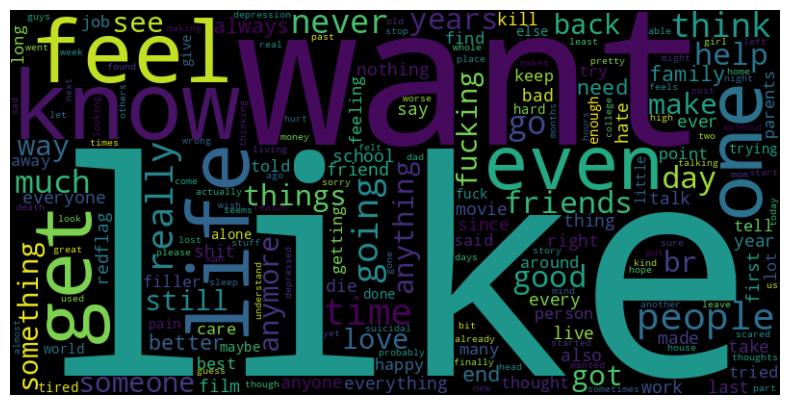

In [25]:
df_words = df.select(explode("filtered").alias("word"))

# Filter out common words or stop words if necessary
# You can use the 'stopwords' parameter in the WordCloud constructor

# Convert the DataFrame to Pandas for WordCloud generation
wordcloud_data = df_words.groupBy("word").count().toPandas()

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="black").generate_from_frequencies(wordcloud_data.set_index("word")["count"].to_dict())

# Display the WordCloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
def remove_empty_strings(array):
   return [x for x in array if x != '']

remove_empty_strings_udf = udf(remove_empty_strings, ArrayType(StringType()))

df = df.withColumn("lemmatized", remove_empty_strings_udf(df["lemmatized"]))

In [27]:
df.show(5)

+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|            filtered|          lemmatized|
+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|music recommendat...|    0|   450|music recommendat...|[music, recommend...|[music, recommend...|[music, recommend...|
|im done trying fe...|    1|   594|i am done trying ...|[i, am, done, try...|[done, trying, fe...|[do, try, feel, b...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|[hey, rredflag, s...|
|trying rd time k ...|    0|    29|trying rd time k ...|[trying, rd, time...|[trying, rd, time...|[try, rd, time, k...|
|got told im lot p...|    0|   141|got told i am lot...|[got, told, i, am...|[got, told, lot, ...|[get, tell, lot, ...|
+--------------------+-----+------+-----

In [28]:
hashingTF = HashingTF(inputCol="lemmatized", outputCol="rawFeatures", numFeatures=4096)
df = hashingTF.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df)
df = idfModel.transform(df)

In [29]:
df.show(5)

+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|            filtered|          lemmatized|         rawFeatures|            features|
+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|music recommendat...|    0|   450|music recommendat...|[music, recommend...|[music, recommend...|[music, recommend...|(4096,[131,178,19...|(4096,[131,178,19...|
|im done trying fe...|    1|   594|i am done trying ...|[i, am, done, try...|[done, trying, fe...|[do, try, feel, b...|(4096,[103,239,28...|(4096,[103,239,28...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|[hey, rredflag, s...|(4096,[39,46,62,2...|(4096,[39,46,62,2...|
|trying rd time k ...|    0|

In [30]:
df = df.drop('tokened')
df = df.drop('filtered')
df = df.drop('lemmatized')
df = df.drop('extracted_text')
df = df.drop('length')

In [31]:
df.show(5)

+--------------------+-----+--------------------+--------------------+
|                text|label|         rawFeatures|            features|
+--------------------+-----+--------------------+--------------------+
|music recommendat...|    0|(4096,[131,178,19...|(4096,[131,178,19...|
|im done trying fe...|    1|(4096,[103,239,28...|(4096,[103,239,28...|
|hey rredflag sure...|    1|(4096,[39,46,62,2...|(4096,[39,46,62,2...|
|trying rd time k ...|    0|(4096,[95,613,273...|(4096,[95,613,273...|
|got told im lot p...|    0|(4096,[353,433,45...|(4096,[353,433,45...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [32]:
(train, test) = df.randomSplit([0.8,0.2], seed=2023)

In [33]:
train = spark.createDataFrame(train.collect())

In [34]:
gb = GBTClassifier(labelCol = 'label', featuresCol = 'features', seed=2023, maxMemoryInMB=1024, maxIter=100, featureSubsetStrategy='auto')

In [35]:
model = gb.fit(train)

In [36]:
predictions = model.transform(test)

In [37]:
pred_result = predictions.collect()

In [38]:
pred_df = spark.createDataFrame(pred_result)

In [39]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'label')

In [40]:
# Extract labels and predictions as lists
labels = labels = pred_df.select("label").rdd.map(lambda x: x[0]).collect()
predicted_labels = labels = pred_df.select("prediction").rdd.map(lambda x: x[0]).collect()
# Find unique labels
unique_labels = sorted(set(labels + predicted_labels))

# Create a confusion matrix
conf_matrix = [[0] * len(unique_labels) for _ in range(len(unique_labels))]

for true_label, pred_label in zip(labels, predicted_labels):
    conf_matrix[int(true_label)][int(pred_label)] += 1

# Display the confusion matrix
print("Confusion Matrix:")
for row in conf_matrix:
    print(row)

Confusion Matrix:
[2984, 0]
[0, 2575]


In [41]:
# Calculate precision, recall, F1 score, and accuracy
precision = evaluator.evaluate(pred_df, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(pred_df, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(pred_df, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_df, {evaluator.metricName: "accuracy"})

# Display the classification report
print("Classification Report:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
Precision: 0.8709
Recall: 0.8701
F1 Score: 0.8700
Accuracy: 0.8701


In [42]:
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(pred_df, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC:", auc)

Area Under ROC: 0.9426213436319018


# Hyperparameter Tuning

In [43]:
import random
class RandomGridBuilder:
  '''Grid builder for random search. Sets up grids for use in CrossValidator in Spark using values randomly sampled from user-provided distributions.
  Distributions should be provided as lambda functions, so that the numbers are generated at call time.

  Parameters:
    num_models: Integer (Python) - number of models to generate hyperparameters for
    seed: Integer (Python) - seed (optional, default is None)

  Returns:
    param_map: list of parameter maps to use in cross validation.

  Example usage:
    from pyspark.ml.classification import LogisticRegression
    lr = LogisticRegression()
    paramGrid = RandomGridBuilder(2)\
               .addDistr(lr.regParam, lambda: np.random.rand()) \
               .addDistr(lr.maxIter, lambda : np.random.randint(10))\
               .build()

    Returns similar output as Spark ML class ParamGridBuilder and can be used in its place. The above paramGrid provides random hyperparameters for 2 models.
    '''

  def __init__(self, num_models, seed=None):
    self._param_grid = {}
    self.num_models = num_models
    self.seed = seed

  def addDistr(self, param, distr_generator):
    '''Add distribution based on dictionary generated by function passed to addDistr.'''

    if 'pyspark.ml.param.Param' in str(type(param)):
      self._param_grid[param] = distr_generator
    else:
      raise TypeError('param must be an instance of Param')

    return self

  def build(self):
    param_map = []
    for n in range(self.num_models):
      if self.seed:
        # Set seeds for both numpy and random in case either is used for the random distribution
        np.random.seed(self.seed + n)
        random.seed(self.seed + n)
      param_dict = {}
      for param, distr in self._param_grid.items():
        param_dict[param] = distr()
      param_map.append(param_dict)

    return param_map



In [44]:
# Create an evaluator
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Create a GBTClassifier instance
gb = GBTClassifier(featuresCol="features", labelCol="label")

# Use RandomGridBuilder to generate a random hyperparameter grid
param_grid = (RandomGridBuilder(num_models=10, seed=2023)
              .addDistr(gb.maxDepth, lambda: np.random.randint(5, 16))  # Randomize maxDepth between 5 and 15
              .addDistr(gb.maxBins, lambda: np.random.choice([32, 64, 128]))  # Randomly choose from maxBins options
              .addDistr(gb.maxIter, lambda: np.random.choice([10, 15, 20, 25, 30]))  # Randomly choose from maxIter options
              .addDistr(gb.seed, lambda: 2023)  # Fixed seed
              .addDistr(gb.stepSize, lambda: np.random.choice([0.1, 0.05]))  # Randomly choose from stepSize options
              .addDistr(gb.subsamplingRate, lambda: np.random.choice([0.8, 1.0]))  # Randomly choose from subsamplingRate options
              .addDistr(gb.maxMemoryInMB, lambda: 2048)  # Fixed maxMemoryInMB
              .build())



In [45]:
print(param_grid)

[{Param(parent='GBTClassifier_bd772a57c32a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 12, Param(parent='GBTClassifier_bd772a57c32a', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 64, Param(parent='GBTClassifier_bd772a57c32a', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='GBTClassifier_bd772a57c32a', name='seed', doc='random seed.'): 2023, Param(parent='GBTClassifier_bd772a57c32a', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1, Param(parent='GBTClassifier_bd772a57c32a', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0, Param(parent='GBTClassifier_bd772a57c32a', name='maxMemoryInMB

In [46]:
# Create CrossValidator
crossval = CrossValidator(estimator=gb,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=2)

# Fit the CrossValidator to the training data
cvModel = crossval.fit(train)

In [47]:
# Get the best GBT model
best_gbt_model = cvModel.bestModel

In [48]:
print("Best GBT Model Parameters:")
print(f"Max Depth: {best_gbt_model.getMaxDepth()}")
print(f"Max Bins: {best_gbt_model.getMaxBins()}")
print(f"Max Iterations: {best_gbt_model.getMaxIter()}")
print(f"Best Seed: {best_gbt_model.getSeed()}")
print(f"Best Step Size: {best_gbt_model.getStepSize()}")
print(f"Best Subsampling Rate: {best_gbt_model.getSubsamplingRate()}")
print(f"Best Max Memory (MB): {best_gbt_model.getMaxMemoryInMB()}")

Best GBT Model Parameters:
Max Depth: 7
Max Bins: 128
Max Iterations: 30
Best Seed: 2023
Best Step Size: 0.1
Best Subsampling Rate: 1.0
Best Max Memory (MB): 2048


In [49]:
predictions = best_gbt_model.transform(test)

In [50]:
pred_result = predictions.collect()

In [51]:
pred_df = spark.createDataFrame(pred_result)

In [52]:
# Calculate precision, recall, F1 score, and accuracy
precision = evaluator.evaluate(pred_df, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(pred_df, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(pred_df, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_df, {evaluator.metricName: "accuracy"})

# Display the classification report
print("Classification Report:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
Precision: 0.8583
Recall: 0.8570
F1 Score: 0.8567
Accuracy: 0.8570


# Result

In [53]:
# create predict one
def predict_one(text):
    df_one = spark.createDataFrame([(text,)], ['text'])
    # remove symbols with regex
    df_one = df_one.withColumn('text', regexp_replace(col('text'), '[^\sa-zA-Z0-9]', ''))
    # lowercase
    df_one = df_one.withColumn('text', lower(col('text')))
    # extract text
    df_one = df_one.withColumn('extracted_text', extract_text_udf('text'))
    df_one = tokenizer.transform(df_one)
    df_one = stopwords_remover.transform(df_one)
    df_one = df_one.withColumn('lemmatized', lemmatize_udf(df_one['filtered']))
    df_one = hashingTF.transform(df_one)
    df_one = idfModel.transform(df_one)
    return best_gbt_model.transform(df_one).collect()[0]['prediction']


In [54]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: jnsfjvg
The input suggests negative mental health


In [57]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: i want to kill myself
The input suggests positive mental health.
